<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Turn a ML research paper into usable code

In this notebook we are going to be replicating the Vision Transformer (ViT)

Paper - https://arxiv.org/abs/2010.11929v2



# Anatomy of a research paper

1. Abstract : An *overview/summary* of the paper
2. Introduction: What is the paper's *main problem* ? And details of previous methods used to try and solve it.
3. Method: What *steps did the researchers take* to solve the problem? (Example: Model, Datasource, training setup)
4. Results: What are the *outcomes* of the paper? If a new type of model training setup was used how did the results compare to previous methods?
5. Conclusion: What are the *limitations* of the suggested methods ? What are the *future work* ?
6. References: What *resources/other papers* did the researchers use to build there own body of work?
7. Appendix: Are there any *extra resources/findings* that were not mentioned in the above section of the paper?


## Why replicate machine learning papers

If you want the skills to be a Machine Learning Engineer here are the steps

1. Download a paper
2. Implement it
3. Keep doing this until you have skills
4. Build infrastructure around your models / data preprocessing steps

## Where can we find machine learning research paper

- [arXiv](https://arxiv.org/)
- [AK](https://twitter.com/_akhaliq)
- [Paper With Code](https://paperswithcode.com/)
- [ViT PyTorch](https://github.com/lucidrains/vit-pytorch)

## What are we going to cover

* Getting setup (importing previously written code)
* Introduce a machien elarning paper replicating with PyTorch
* Replicating ViT for FoodVisionMini
* Training a custom ViWaitingForTextObjectMode
* Feature Extraction with a pretrained ViT




# 0. Get setup

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 4036 (delta 1064), reused 1100 (delta 994), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.60 MiB | 37.80 MiB/s, done.
Resolving deltas: 100% (2357/2357), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

The whole goal of what we are trying to do here is to replicate ViT for our FoodVision Mini problem

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 #Table 3 from the ViT Paper


# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [7]:
# Create a batch size of 32 (the paper is using 4096 but due to hardware limitation we will decrease it)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=manual_transforms
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Vizualize a single image

As always, let's adhere to the moto *visualize, visualize, visualize!*

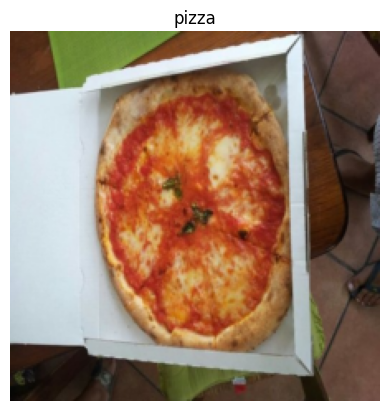

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# Plot the image with myplotlib
plt.imshow(image.permute(1, 2, 0)) # CHW => HWC
plt.axis("off")
plt.title(class_names[label])
plt.show()

## 3. Replicating ViT: Overview

Looking at a whole machine learning paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.


* **Inputs** - What goes into the model? (in our case, image tensor)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classificiation label)
* **Layers** - Takes an input, manipulates it with a function. (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model(Architecture)** - A collection of blocks.

## 3.1 ViT overview: Pieces of the puzzle

* Figure 1: Visual overview of the architrcture
* Four equations: Math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training
* Text

#### Figure 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper" />

* **Embeddings** -  Learnable representation of content(start with random number and improve them over time)

#### Four equations
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper" />

Section 3.1: Describe the various equations

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode ⁉

```python
x_input = [class_token, img_patch_1, img_patch_2...img_patch_N] + [class_token_pos, img_patch_1_pos, img_patch_2_pos,...img_patch_N_pos]
```

---

**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).



```python
# Equation 2

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```
---

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = Multilayer Perceptron = a neural network with x number of layers
* MLP = on hidden layer at training time
* MLP = single linear layer a fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
````
---

#### Table 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper" />

* ViT-Base, ViT-Large, ViT-Huge are all different sizes of the same model architecture
* Layers - the number of transformer encoder layers
* Hidden Size $D$ - the embedding size throught the architecture (each image patch to vector)
* MLP size - the number of hidden units in the MLP
* Heads - number of multi-head self-attention (MSA)
* Params - total number of params in the architecture
---

## 4.Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input => function => output

What's the input shape ?

What's the output shape ?

* Input shape: (224, 224, 3) => Single Image (Hight, Width, Color Channels)
* Output shape: ???

### 4.1 : Calculate input and output shape by hand
**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input Shape: $H\times{W}\times{C}$ (Height x Width x Color Channel)
* Output Shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = Height
* W = Width
* C = Color Channels
* P = Patch size
* N = Number of patches = (height * width) / pˆ2
* D = Constant latent vector size = embedding dimension (see table 1)


In [9]:
# Create examples values

height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate the number of patch
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

#Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)


print(f"Input Shape  (Single 2D Image): {embedding_layer_input_shape}")
print(f"Output Shape (Single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape  (Single 2D Image): (224, 224, 3)
Output Shape (Single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize!*

(-0.5, 223.5, 223.5, -0.5)

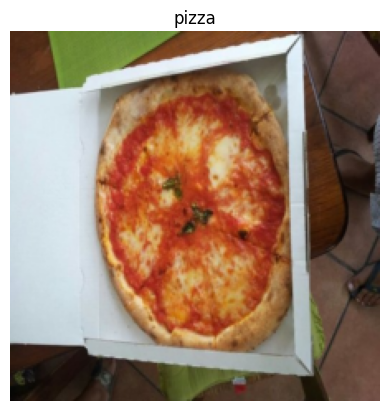

In [11]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
image.shape

torch.Size([3, 224, 224])

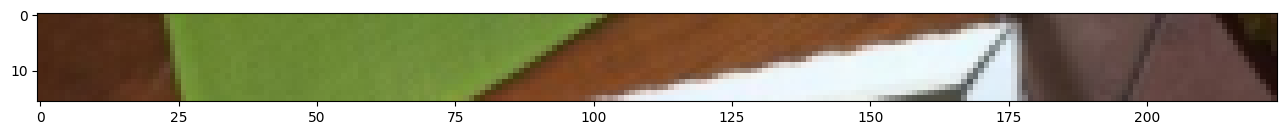

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert image to HWC

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : , :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


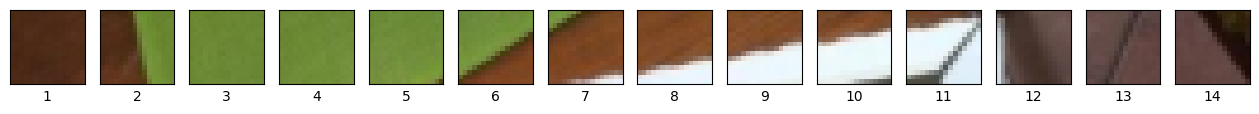

In [14]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisable by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size, # one colum per patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

# Loop through each subplot
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]) # (height, width, color_channels)
  axis[i].set_xlabel(i+1) # Set patch label
  axis[i].set_xticks([])
  axis[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


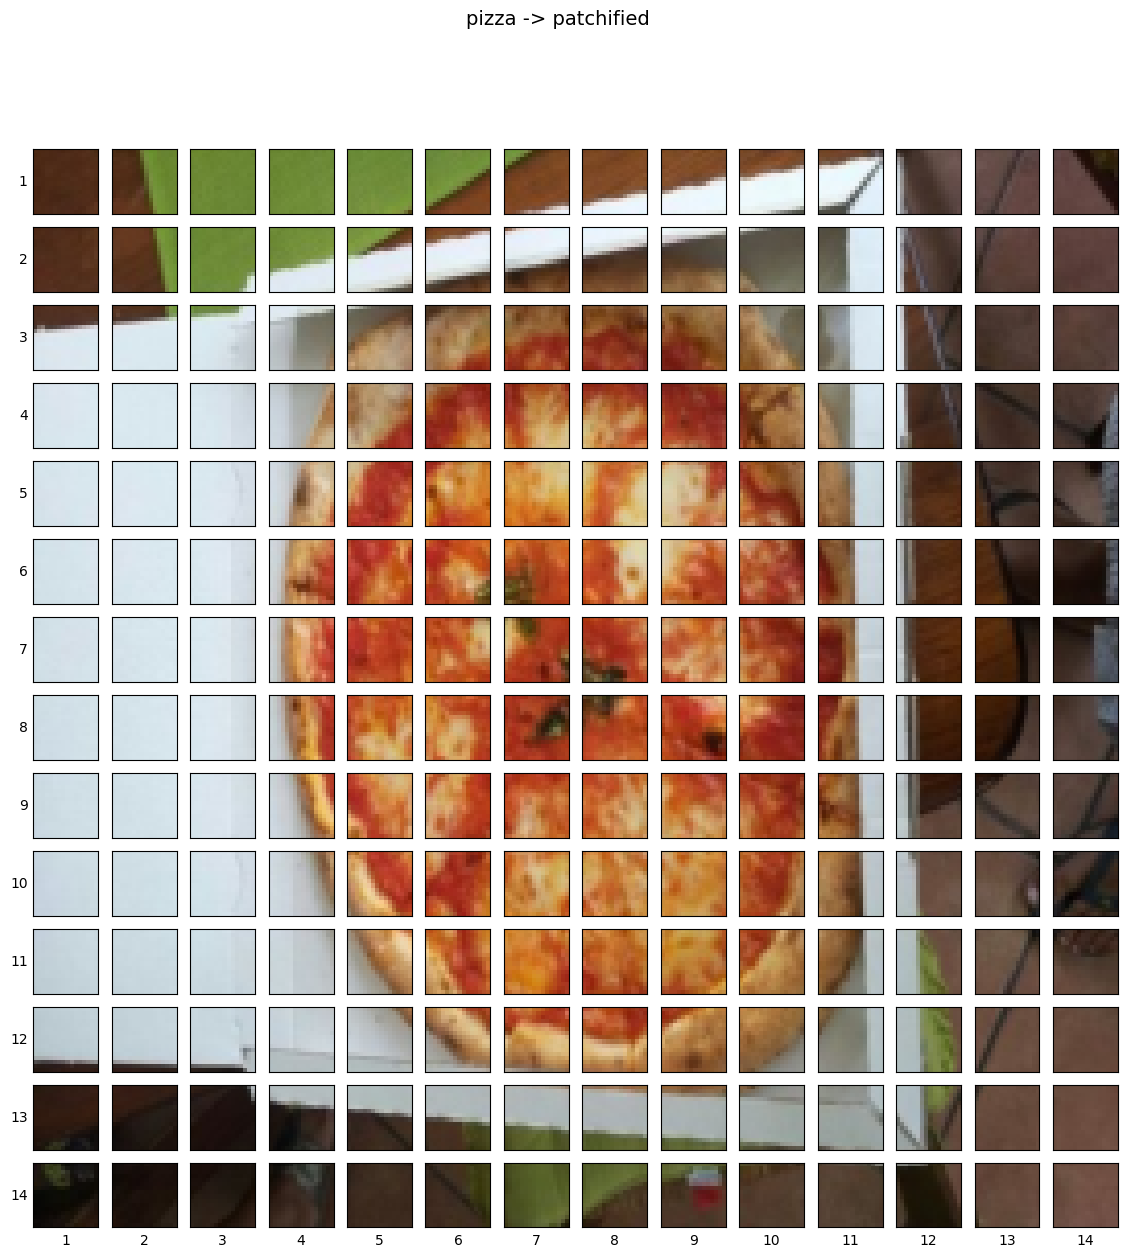

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches * num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=img_size // patch_size,
    ncols=img_size // patch_size,
    sharex=True,
    sharey=True,
    figsize=(num_patches, num_patches)
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
    axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]) # HWC

    # Setup label information
    axis[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
    axis[i, j].set_xlabel(j+1)
    axis[i, j].set_xticks([])
    axis[i, j].set_yticks([])
    axis[i, j].label_outer()

# Setup title
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=14)
plt.show()

### 4.3 Creating images patches and turning them into patch embeddings

Prehaps we could create the mage patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [16]:
# Create conv2d layer to turn image into patches of learnabe feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT architecture
conv2d = nn.Conv2d(
    in_channels=3, # for color channels
    out_channels=768, # D size from table 1
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

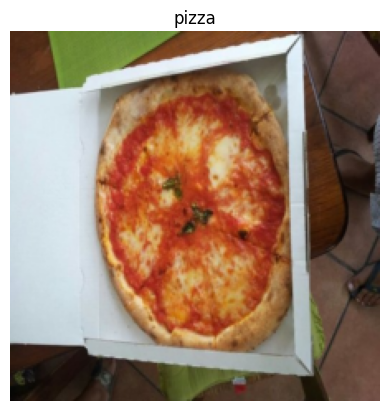

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
# Pass the image through the convolution layer
image_out_of_conv2d = conv2d(image.unsqueeze(0)) #Add batch dimenssion -> (batch_size, color_channels, height, width)
print(image_out_of_conv2d.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [515, 337, 101, 88, 539]


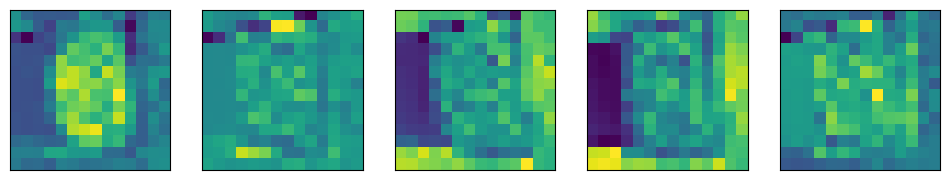

In [19]:
# plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12, 12)
)

# Plot random image feature map
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv2d[:, idx, :, :] # Index on the output tensor
  axis[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove the batch dimension
  axis[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv2d[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad



(tensor([[[-0.1161, -0.0990, -0.0864, -0.0939, -0.0883, -0.1173, -0.2667,
           -0.1537, -0.1049,  0.0693, -0.1119, -0.1093, -0.0984, -0.1553],
          [-0.0997, -0.0788, -0.1355,  0.0103,  0.1349, -0.1181, -0.2099,
           -0.2577, -0.1321, -0.1176,  0.0847, -0.2084, -0.0752, -0.0931],
          [ 0.0102, -0.0185, -0.0711, -0.1438, -0.1522, -0.1945, -0.1984,
           -0.1513, -0.1791, -0.1859,  0.0174, -0.1853, -0.0671, -0.0951],
          [-0.1100, -0.1124, -0.1247, -0.2816, -0.1907, -0.3215, -0.3345,
           -0.2636, -0.2289, -0.1476,  0.0346, -0.1160, -0.0432,  0.0551],
          [-0.1084, -0.1170, -0.1202, -0.1543, -0.3550, -0.3243, -0.2306,
           -0.2207, -0.2989, -0.1867, -0.0067, -0.2408, -0.0684, -0.0615],
          [-0.1060, -0.1162, -0.1281, -0.2467, -0.3032, -0.3256, -0.2826,
           -0.1418, -0.3270, -0.2723, -0.0201, -0.2086, -0.0671,  0.0818],
          [-0.1053, -0.1047, -0.1285, -0.3730, -0.3426, -0.1505, -0.2877,
           -0.2546, -0.3156, -0.

### 4.4 Flattening the patch embedding with `nn.Flatten()`

In [21]:
# torch.Size([1, 768, 14, 14]) => (batch_size, emdbedding_dim, feature_map_height, feature_map_width)

# Flatten to sequence
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flattened_image = flatten_layer(image_out_of_conv2d)
flattened_image.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature maps (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


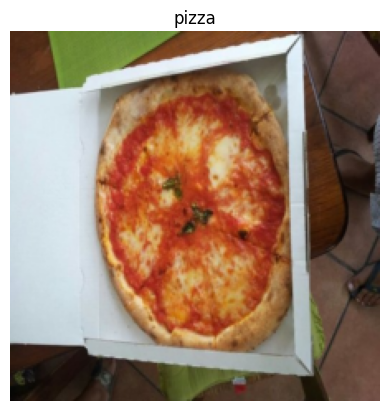

In [22]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv2d = conv2d(image.unsqueeze(0)) #Add batch dimenssion -> (batch_size, color_channels, height, width)
print(f"Image feature maps (patches) shape: {image_out_of_conv2d.shape}")

# Flatten the feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv2d)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [23]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


(-0.5, 195.5, 0.5, -0.5)

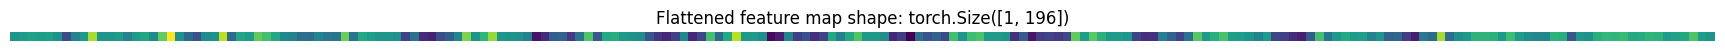

In [24]:
# Visualizing a single flattened patch embeddings vector

single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map.shape

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch Module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialized with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()`that define the forward computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [25]:
# Step 1 : Create class called patch embeddding

class PatchEmbedding(nn.Module):

    # 2. Initialize the layer with the appropriate hyperparameters
    def __init__(
        self,
        in_channels: int = 3,
        patch_size: int = 16,
        embedding_dim: int = 768 # From the ViT paper table 1
    ):
      super().__init__()
      self.patch_size=patch_size


      # 3. Create a layer to turn image into embedding patches
      self.patcher = nn.Conv2d(
          in_channels=in_channels,
          out_channels=embedding_dim,
          kernel_size=patch_size,
          stride=patch_size,
          padding=0
      )
      # 4. Create flatten layer to flatten feature map of conv 2d
      self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # 5. Define a forward() that define the forward computation
    def forward(self, x):
      # 6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

      # Create assertion to check the inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)

      #7. Make sure the return sequence embedding are in the right order (batch_size, number_of_patches, embedding_dimenssion)
      return x_flattened.permute(0, 2, 1)

In [26]:
set_seeds()

# Create an instance of patch embedding
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through patch embedding layer
print(f"Input image size : {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embeddding sequence shape : {patch_embedded_image.shape}")

Input image size : torch.Size([1, 3, 224, 224])
Output patch embeddding sequence shape : torch.Size([1, 196, 768])


In [27]:
read_image_tensor = torch.randn(1, 3, 224, 224)
read_image_tensor_bad = torch.randn(1, 3, 250, 250)

In [28]:
patchify(read_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [29]:
patchify(read_image_tensor_bad)

AssertionError: ignored

### 4.6 Creating the class token embedding

Want to : prepend a learnable class token to the start of the patch embedding

In [30]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [32]:
# Get the batch size and embeddding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

In [33]:
# Create a class token embedding as a learnable paameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat([class_token, patch_embedded_image], dim=1) # number_of_patches dimension
patch_embedded_image_with_class_embedding.shape

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, number_of_patches + class_token, embedding_dim)")



tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2674,  0.0142, -0.0556,  ...,  0.1379, -0.1227,  0.0846],
         [-0.4077,  0.1739, -0.1067,  ...,  0.3055, -0.1673, -0.0046],
         ...,
         [-0.1193,  0.0695, -0.0387,  ...,  0.0492, -0.1400,  0.1225],
         [-0.3580,  0.0564, -0.0879,  ...,  0.2149, -0.1619,  0.1377],
         [-0.4094,  0.0598, -0.0835,  ...,  0.2624, -0.1853,  0.1290]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + class_token, embedding_dim)


### 4.6 Creating the position embedding

Want to: create. a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [35]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2674,  0.0142, -0.0556,  ...,  0.1379, -0.1227,  0.0846],
          [-0.4077,  0.1739, -0.1067,  ...,  0.3055, -0.1673, -0.0046],
          ...,
          [-0.1193,  0.0695, -0.0387,  ...,  0.0492, -0.1400,  0.1225],
          [-0.3580,  0.0564, -0.0879,  ...,  0.2149, -0.1619,  0.1377],
          [-0.4094,  0.0598, -0.0835,  ...,  0.2624, -0.1853,  0.1290]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number_of_patches)
number_of_patch = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding

position_embedding = nn.Parameter(
    torch.ones(
        1,
        number_of_patches+1,
        embedding_dimension
    ),
    requires_grad=True
)
position_embedding, position_embedding.shape



(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7326, 1.0142, 0.9444,  ..., 1.1379, 0.8773, 1.0846],
          [0.5923, 1.1739, 0.8933,  ..., 1.3055, 0.8327, 0.9954],
          ...,
          [0.8807, 1.0695, 0.9613,  ..., 1.0492, 0.8600, 1.1225],
          [0.6420, 1.0564, 0.9121,  ..., 1.2149, 0.8381, 1.1377],
          [0.5906, 1.0598, 0.9165,  ..., 1.2624, 0.8147, 1.1290]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embedding

Let's do it all in one cell


In [38]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shape of the original image and get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape:{x.shape}")

# 4. Create the patch embedding layer
patch_embedding_layer = PatchEmbedding()

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension= patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(
        batch_size,
        1,
        embedding_dimension
    ),
    requires_grad=True
)
print(f"Class token shape: {class_token.shape}")

# 7. prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int(height * width / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(
        1,
        number_of_patches+1,
        embedding_dimension
    ),
    requires_grad=True
)
print(f"Position embedding shape: {position_embedding.shape}")

# 9. Add the position embedding to the patch and class token embedding
patch_embedding_class_token_position = patch_embedding_class_token + position_embedding
print(f"Patch embedding with class token and position embedding shape: {patch_embedding_class_token_position.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape:torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch embedding with class token and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA)

* Multihead Self-Attention (MSA) : Which part of the sequence should pay the most attention to itself ?
  * In our cas we have a series of embedded image patches, which patche significantly relates to other patch.
  * To replicate MSA in PyTorch we can use : https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalize: Make everything have the same mean and the same standard deviation
  * In PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes the value over $D$ dimension, in our cas the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stair in a staircase the same size.


In [53]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Create a multi-head self-attention block (MSA)."""

  def __init__(
      self,
      embedding_dim: int=768,
      num_heads:int=12,
      attn_dropout:float=0.0,
    ):
    super().__init__()


    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(
        normalized_shape=embedding_dim
    )

    # Create the multi-head attention layer
    self.multi_head_attention = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True # is the batch first (batch, sequence, feature) => (batch, number_of_patches, embedding_dimension)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multi_head_attention(
        query=x,
        key=x,
        value=x,
        need_weights=False
    )

    return attn_output

In [40]:
# Create an instance of MSA block
multi_head_self_attention_block = MultiHeadSelfAttentionBlock()


# Pass the patch and position image embedding sequence throught the MSA Block
patch_Image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Patch image through MSA block shape: {patch_Image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Patch image through MSA block shape: torch.Size([1, 197, 768])


# 6. Equation 3: Multilayer Perceptron (MLP Block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (Section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer
  * MLP number of hidden units = MLP Size in Table 1
  * Layers can mean: fully-connected, dense, linear, feed-forward all are often similar names for the same thing. In PyTorch they're often callled `torch.nn.Linear()` in TensorFlow they might be called `tf.keras.layer.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#gelu
  * Dropout value available in Table 3

In pseudocode 🇰
```Python
#MLP
x = linear => non-linear => dropout => linear => dropout



In [47]:
class MLPBlock(nn.Module):
  """Create a MLP block."""

  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    # Create the norm layer
    self.layer_norm = nn.LayerNorm(
        normalized_shape=embedding_dim
    )

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(
            in_features=embedding_dim,
            out_features=mlp_size
        ),
        nn.GELU(),
        nn.Dropout(
            p=dropout
        ),
        nn.Linear(
            in_features=mlp_size,
            out_features=embedding_dim
        ),
        nn.Dropout(
            p=dropout
        )
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    # With operator fusion return self.mlp(self.layer_norm(x))
    return x

In [50]:
# Create an instance of MLP Block
mlp_block = MLPBlock(
    embedding_dim=768,
    mlp_size=3072,
    dropout=0.1
)

# Pass the output of the MSABlock through the MLP Block
patched_image_through_mlp_block = mlp_block(patch_Image_through_msa_block)
print(f"Input shape of MLP block: {patch_Image_through_msa_block.shape}")
print(f"Output shape  of MLP block: {patched_image_through_mlp_block.shape}")



Input shape of MLP block: torch.Size([1, 197, 768])
Output shape  of MLP block: torch.Size([1, 197, 768])


### 7. Creating a Custom Transformer Encoder Block

The transformer encoder is a combination of alternating block MSA (equation 2) and MLP (equation 3)

And there is residual connection between the blocks.

* Encoder = Turn a sequence into a learnable reprentation
* Decoder = Go from learned representation to some kind of sequence
* Residual connections = add a layers(s) to it subsequent output, this enable the creation of deeper networks (prevent weights from getting to small)

In pseudocode:
```python
# Transformer Encoder
x_input => MSA Block => [MSA Block Output + x_input] => MLP BLock => [MLP Block Output + MSA block output = x_input] => ...
```

    


In [55]:
from ssl import ALERT_DESCRIPTION_RECORD_OVERFLOW
class TransformerEncoderBlock(nn.Module):
  """Create a Transformer Encoder Block."""
  def __init__(
      self,
      embedding_dim:int=768,
      num_heads:int=12,
      mlp_size:int=3072,
      mlp_dropout:float=0.1,
      attn_dropout:float=0.0,
    ):

      super().__init__()

      # Create the MSA Block (equation 2)
      self.msa_block = MultiHeadSelfAttentionBlock(
          embedding_dim=embedding_dim,
          num_heads=num_heads,
          attn_dropout=attn_dropout
      )

      # Create the MLP Block (equation 3)
      self.mlp_block = MLPBlock(
          embedding_dim=embedding_dim,
          mlp_size=mlp_size,
          dropout=mlp_dropout
      )

  def forward(self, x):
    x = self.msa_block(x) + x # residual connection (skip connection) => Resnet
    x = self.mlp_block(x) + x # residual connection (skip connection) => Resnet
    return x

In [57]:
# Create an instance of TransformerEncodeBlock

transformer_encoder_block = TransformerEncoderBlock(
    embedding_dim=768,
    num_heads=12,
    mlp_size=3072,
    mlp_dropout=0.1,
)

# Get a summary using torchinfo.summary
summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768), # batch_size, number_of_patches, embedding_dimenssion
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.1 Create a custom Transformer Encoder Layer with inbuilt pytorch

So far we've created a transformer encoder by hand.

But because how good the transformer architecture is so go pytorch already offers pre-built layer for transformer_encoder_block

See - https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a transformer with pure PyTorch Layer

In [59]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,  #embedding size
    nhead=12,  # heads from table 1
    dim_feedforward=3072, #MLP size from table 1
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [60]:
summary(
    model=transformer_encoder_layer,
    input_size=(1, 197, 768), # batch_size, number_of_patches, embedding_dimenssion
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just used the pre-built layer?

Practice, Practice, Practice

Now we know how things are implemented behind the scene we can tweak them if necessary !

What are the benifits of using a pre-built PyTorch layer ?
* Less prone to error
* Performance boost